# Training Potts Models with Contrastive Divergence for Protein Design

In [ ]:
!git clone https://github.com/igemto-drylab/CSBERG-ML.git
%cd CSBERG-ML
from util import *
import tqdm.notebook as tq
%cd ..

Cloning into 'CSBERG-ML'...
remote: Enumerating objects: 158, done.
remote: Counting objects: 100% (158/158), done.
remote: Compressing objects: 100% (153/153), done.
remote: Total 158 (delta 71), reused 19 (delta 2), pack-reused 0
Receiving objects: 100% (158/158), 17.10 MiB | 15.76 MiB/s, done.
Resolving deltas: 100% (71/71), done.
/content/CSBERG-ML
/content


In [ ]:
plt.rcParams['figure.dpi'] = 350

## GREMLIN

https://github.com/whbpt/GREMLIN_PYTORCH/blob/master/GREMLIN_pytorch.ipynb

Also see https://github.com/HussainAther/potts/blob/main/notebooks/CSC412_Potts_Proteins_hussain.ipynb

### bmDCA

**Important Notes:**

*  All amino acids must be upper case

https://github.com/ranganathanlab/bmDCA

In [ ]:
!git clone https://github.com/ranganathanlab/bmDCA.git

Cloning into 'bmDCA'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 1679 (delta 15), reused 22 (delta 10), pack-reused 1646
Receiving objects: 100% (1679/1679), 790.26 KiB | 13.17 MiB/s, done.
Resolving deltas: 100% (1152/1152), done.


In [ ]:
!sudo apt-get update
!sudo apt-get install git gcc g++ automake autoconf pkg-config \
  libarmadillo-dev libopenblas-dev libarpack++2-dev

Get:1 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:2 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:4 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:5 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:6 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:7 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:8 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:9 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease [21.3 kB]
Ign:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:11 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:13 https://developer.download

In [ ]:
%cd bmDCA
!bash autogen.sh --prefix=/usr/local && \
%cd ..

/content/bmDCA
configure.ac:8: installing './config.guess'
configure.ac:8: installing './config.sub'
configure.ac:35: installing './install-sh'
configure.ac:35: installing './missing'
src/Makefile.am: installing './depcomp'
+ ./configure --prefix=/usr/local
checking build system type... x86_64-pc-linux-gnu
checking host system type... x86_64-pc-linux-gnu
checking for a BSD-compatible install... /usr/bin/install -c
checking whether build environment is sane... yes
checking for a thread-safe mkdir -p... /bin/mkdir -p
checking for gawk... no
checking for mawk... mawk
checking whether make sets $(MAKE)... yes
checking whether make supports nested variables... yes
checking whether to enable maintainer-specific portions of Makefiles... yes
checking whether make supports nested variables... (cached) yes
checking for g++... g++
checking whether the C++ compiler works... yes
checking for C++ compiler default output file name... a.out
checking for suffix of executables... 
checking whether we ar

In [ ]:
%%shell
cd bmDCA
make -j4 && \
make install
cd ..

/bin/bash: line 0: cd: bmDCA: No such file or directory
Making all in src
make[1]: Entering directory '/content/bmDCA/src'
  CXX      model.o
  CXX      msa_stats.o
  CXX      bmdca.o
  CXX      msa.o
  CXX      run.o
  CXX      mcmc.o
  CXX      mcmc_stats.o
  CXX      graph.o
  CXX      utils.o
run.cpp: In constructor ‘Sim::Sim(MSAStats, std::__cxx11::string, std::__cxx11::string, bool)’:
run.cpp:383:10: warning: ignoring return value of ‘int chdir(const char*)’, declared with attribute warn_unused_result [-Wunused-result]
     chdir(dest_dir.c_str());
     ~~~~~^~~~~~~~~~~~~~~~~~
  CXX      bmdca_sample.o
  CXX      generator.o
  CXX      arma_convert.o
bmdca_sample.cpp: In function ‘int main(int, char**)’:
bmdca_sample.cpp:124:10: warning: ignoring return value of ‘int chdir(const char*)’, declared with attribute warn_unused_result [-Wunused-result]
     chdir(dest_dir.c_str());
     ~~~~~^~~~~~~~~~~~~~~~~~
  CXX      fasta_convert.o
  CXXLD    bmdca_sample
  CXXLD    bmdca
  CXXLD

In [ ]:
!mkdir results

In [ ]:
%cd /content

/content


#### Training

In [ ]:
def read_fasta(fname, onehot=True):
    seqs = []
    seq_list = []
    s = ""
    with open(fname) as f:
        line = f.readline()
        while line:
            if line.startswith(">"):
                if s != "":
                    seqs.append(s)
                s = ""
            elif len(line) > 0:
                s += line.strip()
            line = f.readline()
        seqs.append(s)
        seq_list.append(list(s))
    if onehot:
        return get_X(seqs)
    else:
        return np.array(seqs)

def read_fasta_seqs(fname):
    seqs = []
    s = ""
    with open(fname) as f:
        line = f.readline()
        while line:
            if line.startswith(">"):
                if s != "":
                    seqs.append(list(s))
                s = ""
            elif len(line) > 0:
                s += line.strip()
            line = f.readline()
        seqs.append(list(s))
    return np.array(seqs)

In [ ]:
def trim_seqs(seqs, save_name):
    """
    seqs: sequences (list of letters not one-hot encoded)
    save_name: output fasta filename

    """
    mask = np.zeros(len(seqs[0]), dtype=np.bool)
    for i in range(len(seqs[0])):
        gaps = 0
        for s in seqs:
            if s[i] == '-':
                gaps += 1
        if gaps/len(seqs) < 0.67:   # keep positions where less than 2/3rd are gaps
            mask[i] = True
    seqs = seqs[:,mask]

    towrite = ""
    for i in range(len(seqs)):
        if sum(seqs[i][100:] == "-") < 50:  # don't take sequences with many gaps
            towrite += ">{}\n".format(i)
            seq = "".join(seqs[i][:]) + "\n"
            towrite += seq.upper()   
    with open(save_name,'w') as f:
        f.write(towrite)

In [ ]:
seqs = read_fasta_seqs("/content/lcc_pfam.txt")
trim_seqs(seqs, "lcc_short.fasta")

In [ ]:
%%shell
rm results/*
bmdca -i lcc_short.fasta -r -d /content/results

15047 sequences
227 positions
21 amino acids (including gaps)
9318.1 effective sequences
initializing run... 5.29271 sec

Step: 1
sampling model with mcmc... 7.80018 sec
updating mcmc with samples... 4.8794 sec
computing sequence energies and correlations... 0.3637 sec
computing mcmc 1p and 2p statistics... 2.44098 sec
computing error and updating gradient... 1.53069 sec
update learning rate... 0.227634 sec
updating parameters... 0.230206 sec

Step: 2
sampling model with mcmc... 7.64549 sec
updating mcmc with samples... 4.84465 sec
computing sequence energies and correlations... 0.370797 sec
computing mcmc 1p and 2p statistics... 2.48229 sec
computing error and updating gradient... 1.54458 sec
update learning rate... 0.223336 sec
updating parameters... 0.220518 sec

Step: 3
sampling model with mcmc... 7.638 sec
updating mcmc with samples... 4.85864 sec
computing sequence energies and correlations... 0.367031 sec
computing mcmc 1p and 2p statistics... 2.4813 sec
computing error and upda

In [ ]:
!tar -czf boltzmann.tar.gz results/*

#### Sampling

Change temperature in a config file

In [ ]:
!pwd

/content/bmDCA


In [ ]:
%%shell
bmdca_sample -p /content/parameters_h_60.bin -P /content/parameters_J_60.bin \
             -d /content -o samples.txt -n 1000 -r 20

initializing sampler... 10.5466 sec

sampling model with mcmc... 122.619 sec
updating mcmc stats with samples... 10.7612 sec
computing sequence energies and correlations... 0.976815 sec
writing final sequences... done


Convert numeric samples into FASTA sequences

In [ ]:
# this AA to IDX mapping is specifically for bmDCA
AA = list("-ACDEFGHIKLMNPQRSTVWY")
AA_IDX = {AA[i]:i for i in range(len(AA))}
IDX_AA = {i:AA[i].upper() for i in range(len(AA))}

def int2fasta(in_name, out_name):
    """
    in_name: filename of samples as outputed from bmDCA
    out_name: name of fasta file output
    """
    towrite = ""

    with open(in_name, 'r') as f:
        line = f.readline()
        line = f.readline()
        id = 1
        while line:
            aanums = line.split()
            seqlist = [IDX_AA[int(aa)] for aa in aanums]
            towrite += ">{}\n".format(id)
            towrite += "".join(seqlist) + "\n"
            line = f.readline()
            id += 1

    with open(out_name, 'w') as f:
        f.write(towrite)

# int2fasta("/content/MC_samples_60.txt", "samples.fasta")

#### Likelihoods

Doesn't come with a function, so implement it ourselves by using the learned parameters $\mathbf{h}, \mathbf{J}$.

In [ ]:
L = 227   # sequence length
q = 21  # number of tokens  (this is 'A' in the GREMLIN code)

h = torch.from_numpy(np.random.randn(L*q))           # fields    (this is b0 in GREMLIN)
J = torch.from_numpy(np.random.randn(L*q, L*q))      # couplings (this is W0 in GREMLIN)


# compute the energy logexp(.) for a sequence s

def logE(s, h, J):
    """
    s: sequence
    h: fields vector (L*q)
    J: couplings matrix (L*q, L*q)
    """
    # compute indicies of s by adding to it [0, 0, 0, ... 21, 21, 21 ...]
    if not torch.is_tensor(s):
        s = torch.from_numpy(s)
    # print(s)
    # print(torch.linspace(0, q*(L-1), L))
    s_idx = s + torch.linspace(0, q*(L-1), L).type(torch.LongTensor).to(device)
    sum_h = torch.sum(h[s_idx])
    j_idx = torch.meshgrid(s_idx, s_idx)
    sum_J = torch.sum(J[j_idx])
    return -(sum_h + sum_J)

# convert list of M sequences of length L each into an MxL matrix of numbers in [0,20]

def seq2num(s):
    nums = []
    for aa in s:
        try:
            nums.append(AA_IDX[aa.upper()])
        except KeyError:
            return None
    return nums

def get_numerical_aas(fname):
    mat = []
    s = ""
    with open(fname) as f:
        line = f.readline()
        while line:
            if line.startswith(">"):
                if s != "":
                    aanums = seq2num(s)
                    if aanums is not None:
                        mat.append(aanums)
                s = ""
            elif len(line) > 0:
                s += line.strip()
            line = f.readline()
    return np.array(mat)

Get the in-distribution sequences (this is just the training data)

In [ ]:
import numpy as np

in_dist = get_numerical_aas("lcc_short.fasta")

Get the out-of-distribution sequences. We construct these sequences in the following ways:



*   Let $S$ be an in-distribution sequence. We take $S'$ to be the shuffled $S$ which is likely out-of-distribution.
*   Let $S=S_1S_2$ be an in-distribution sequence. We assume that $S''=S_2S_1$ is out-of-distribution. This corresponds to swapping the two ends of the protein chain which is likely to disrupt the protein fold.



In [ ]:
out_dist1 = np.array([np.random.permutation(s) for s in in_dist])

In [ ]:
out_dist2 = np.array([np.concatenate((s[int(L/2):], s[:int(L/2)])) for s in in_dist])

Compute $\log \frac{P(S)}{P(S')}$

In [ ]:
in_ratios = []
out_ratios = []
in_out1_ratios = []
in_out2_ratios = []
for i in tq.tqdm(range(200)):
    in_out1_ratios.append(logE(in_dist[i], h, J).item() - logE(out_dist1[i], h, J).item())
    in_out2_ratios.append(logE(in_dist[i], h, J).item() - logE(out_dist2[i], h, J).item())
    in_ratios.append(logE(in_dist[i], h, J).item() - logE(in_dist[i+1], h, J).item())
    out_ratios.append(logE(out_dist1[i], h, J).item() - logE(out_dist1[i+1], h, J).item())

Text(0, 0.5, 'Density')

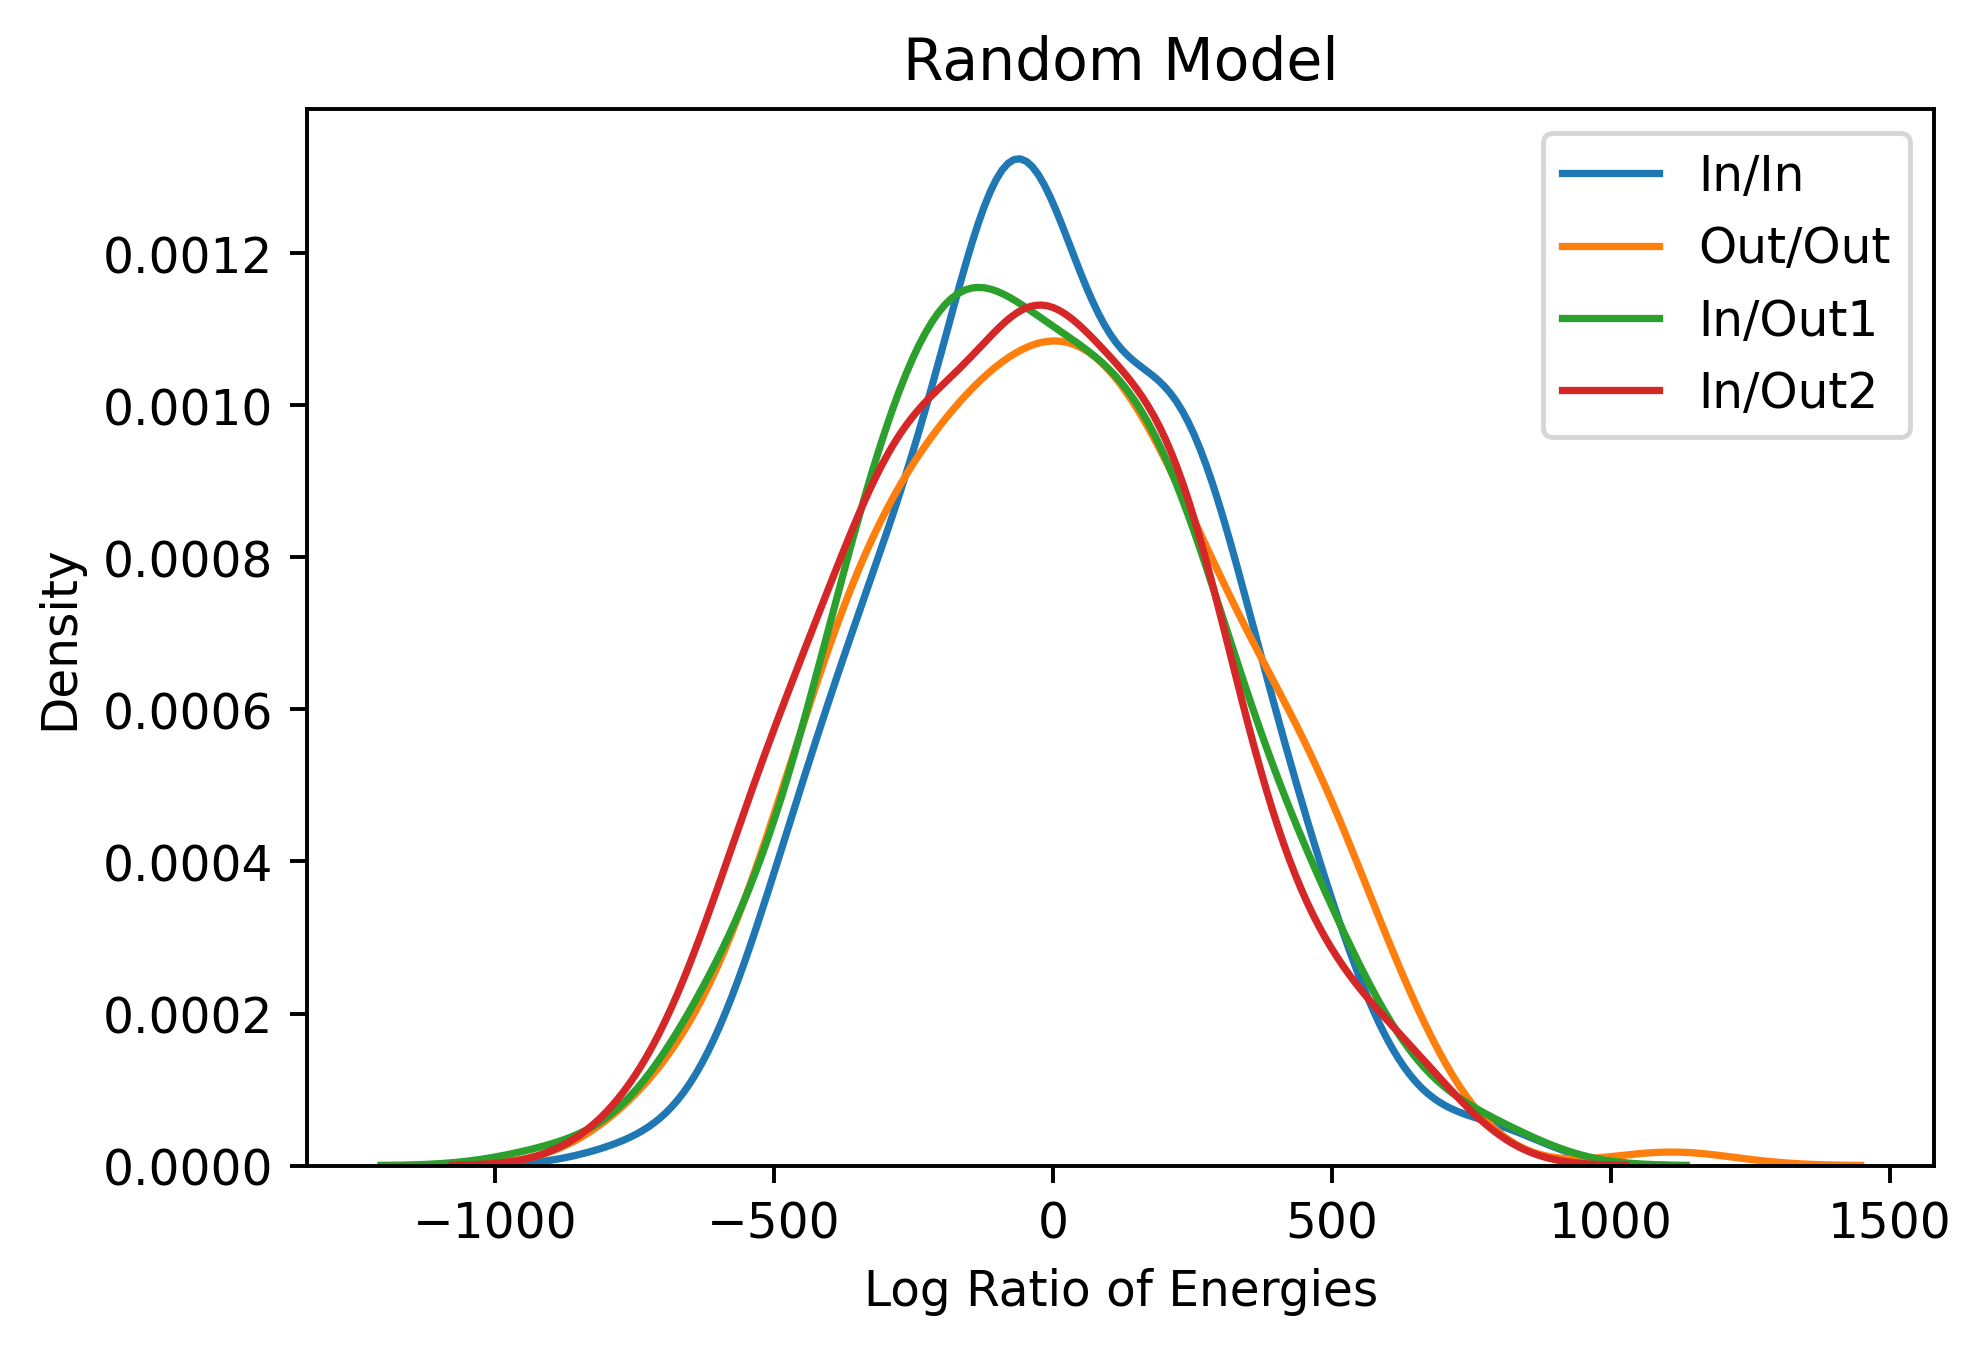

In [ ]:
import seaborn as sns

sns.kdeplot(in_ratios, label = "In/In")
sns.kdeplot(out_ratios, label = "Out/Out")
sns.kdeplot(in_out1_ratios, label = "In/Out1")
sns.kdeplot(in_out2_ratios, label = "In/Out2")

plt.legend()
plt.title('Random Model')
plt.xlabel('Log Ratio of Energies')
plt.ylabel('Density')

Load the $\mathbf{h}, \mathbf{J}$ from bmDCA (took 12 hours to train)

In [ ]:
%%shell
arma2ascii -p parameters_h_60.bin -P parameters_J_60.bin

converting 'parameters_h_60.bin' and 'parameters_J_60.bin' to text... done


Convert parameters from .txt file to numpy arrays

J [position index i] [position index j] [amino acid index a] [amino acid index b]
.
.
.


h [position index i] [amino acid index a]
.
.
.

In [ ]:
h = np.random.randn(L*q)           # fields    (this is b0 in GREMLIN)
J = np.random.randn(L*q, L*q)      # couplings (this is W0 in GREMLIN)

with open("parameters_60.txt", 'r') as f:
    line = f.readline()
    while line:
        data = line.strip().split()
        if data[0] == 'J':
            i, j, aa1, aa2 = int(data[1]), int(data[2]), int(data[3]), int(data[4])
            J[i*q + aa1, j*q + aa2] = float(data[-1])
        if data[0] == 'h':
            i, aa = int(data[1]), int(data[2])
            h[i*q + aa] = float(data[-1])
        line = f.readline()

KeyboardInterrupt: ignored

In [ ]:
in_ratios = []
out_ratios = []
in_out1_ratios = []
in_out2_ratios = []
for i in tq.tqdm(range(200)):
    in_out1_ratios.append(logE(in_dist[i], h, J) - logE(out_dist1[i], h, J))
    in_out2_ratios.append(logE(in_dist[i], h, J) - logE(out_dist2[i], h, J))
    in_ratios.append(logE(in_dist[i], h, J) - logE(in_dist[i+1], h, J))
    out_ratios.append(logE(out_dist1[i], h, J) - logE(out_dist1[i+1], h, J))

Text(0, 0.5, 'Density')

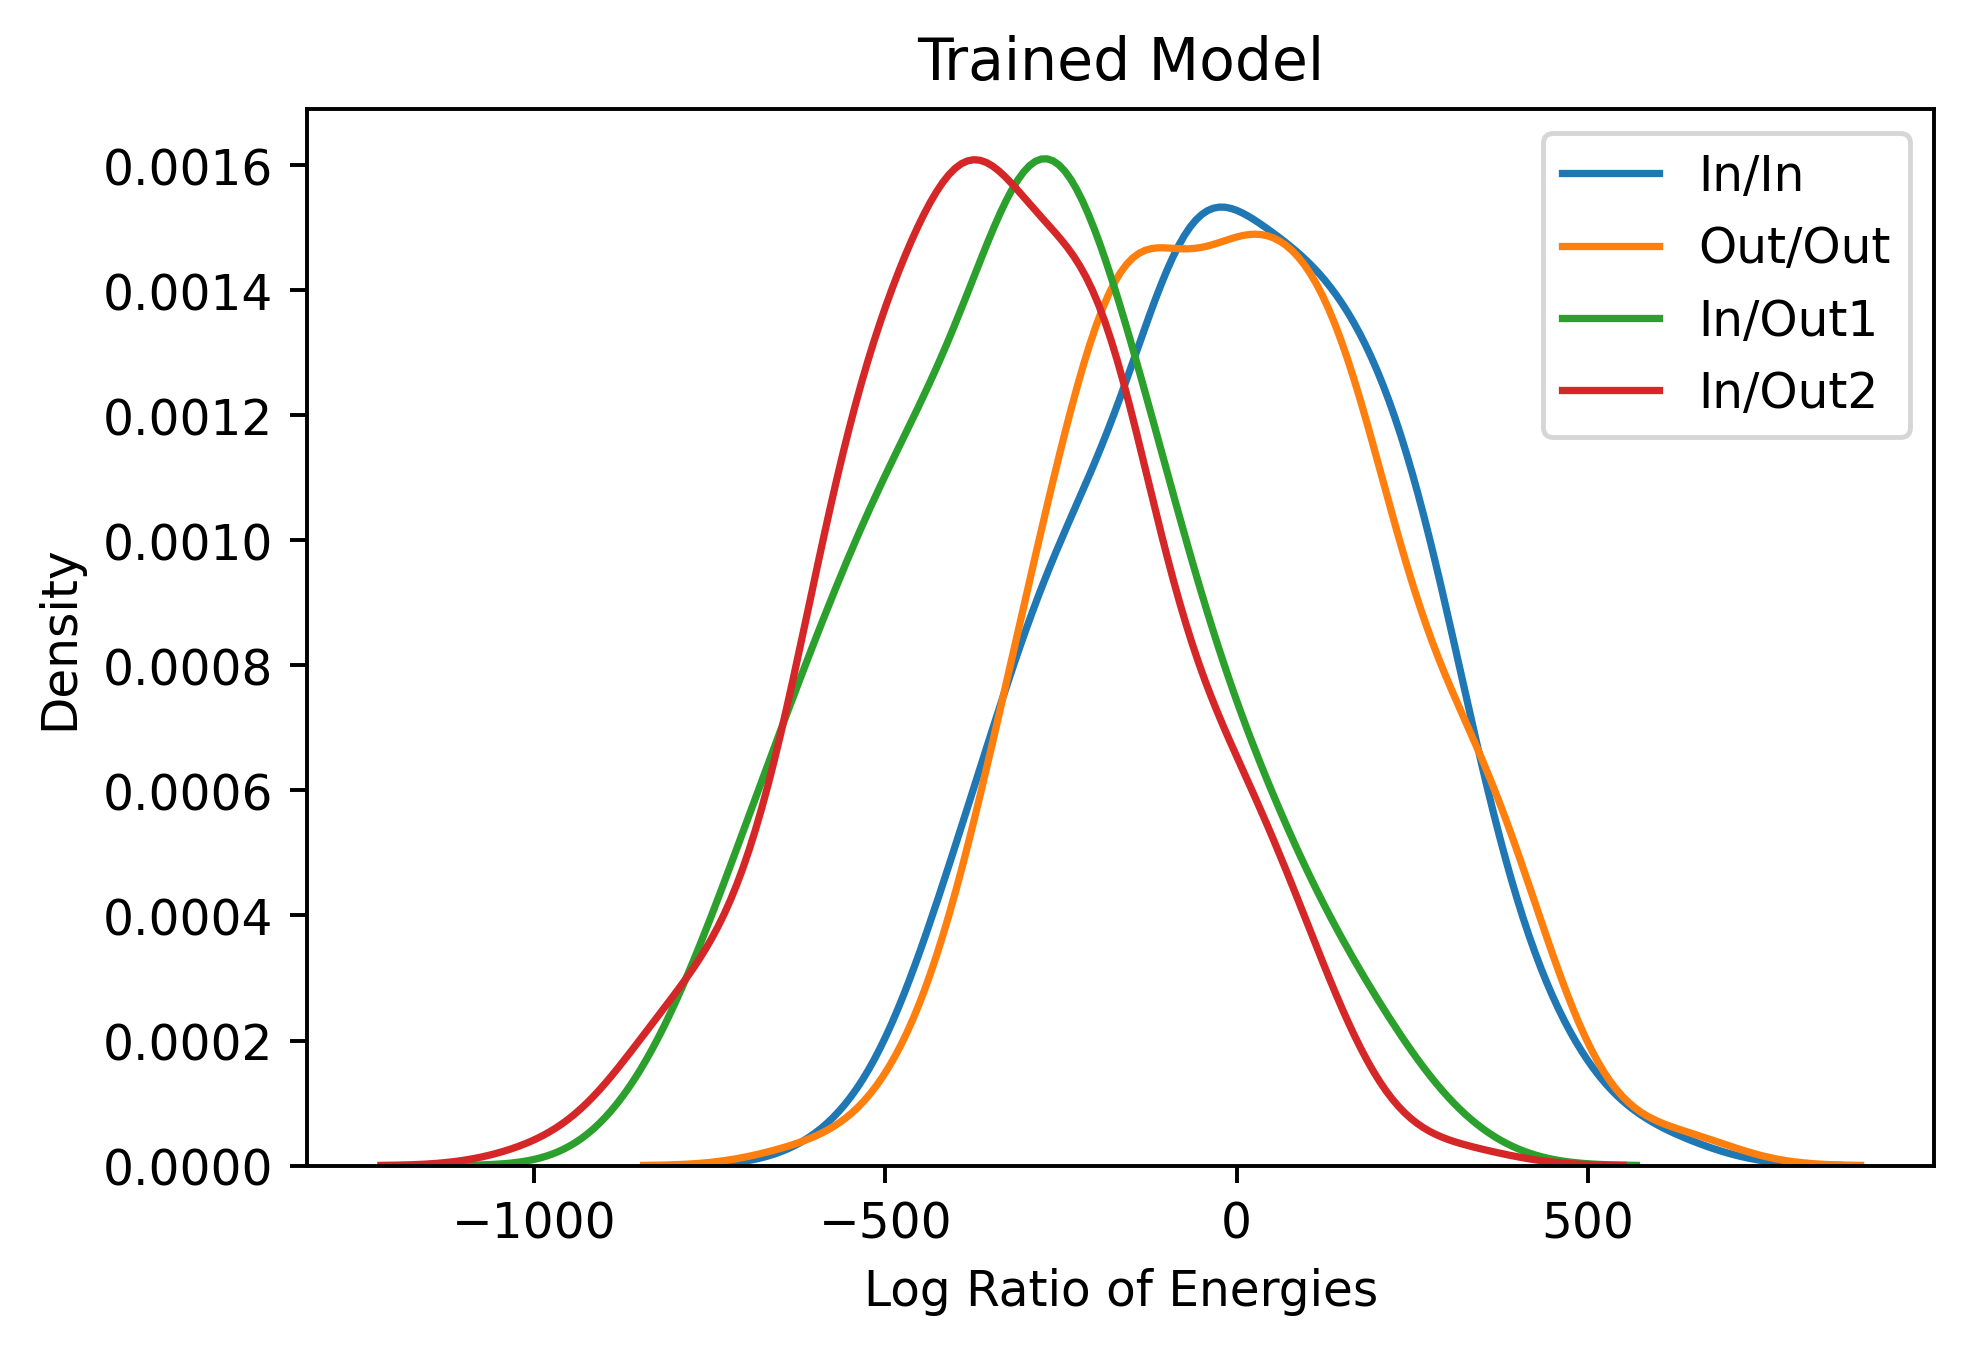

In [ ]:
import seaborn as sns

sns.kdeplot(in_ratios, label = "In/In")
sns.kdeplot(out_ratios, label = "Out/Out")
sns.kdeplot(in_out1_ratios, label = "In/Out1")
sns.kdeplot(in_out2_ratios, label = "In/Out2")

plt.legend()
plt.title('Trained Model')
plt.xlabel('Log Ratio of Energies')
plt.ylabel('Density')

#### First & second order correlations

In [ ]:
from scipy import stats

def first_order(X_data, X_samp, show=True):
    """
    Show scatterplot of the sitewise frequencies of data vs. samples

    Inputs are numpy arrays of shape (batch_size, seq_len, 21)
    """
    b_data, l_data, d_data = X_data.shape
    b_samp, l_samp, d_samp = X_samp.shape
    assert l_data == l_samp
    assert d_data == d_samp

    # sum along the batch dimension
    freqs_data = np.sum(X_data, axis=0).flatten() / b_data
    freqs_samp = np.sum(X_samp, axis=0).flatten() / b_samp

    if show:
        print("Spearman: ", stats.pearsonr(freqs_data, freqs_samp)[0])
        plt.scatter(freqs_data, freqs_samp, s=1, c='red')
        plt.title("First Order Correlations")
        plt.xlabel("Frequencies in data")
        plt.ylabel("Frequences in samples")
        plt.show()
    else:
        return freqs_data, freqs_samp


In [ ]:
aa1, aa2 = np.meshgrid(np.arange(21), np.arange(21))
aa1 = aa1.flatten()
aa2 = aa2.flatten()

def second_order(X_data, X_samp):
    """
    Show scatterplot of the pairwise frequencies of data vs. samples

    Inputs are numpy arrays of shape (batch_size, seq_len, 21)
    """
    data_sites, samp_sites = first_order(X_data, X_samp, show=False)
    b_data, l, d = X_data.shape
    b_samp, l, d = X_samp.shape

    freqs_data = []
    freqs_samp = []
    aas = []
    
    for i in tq.tqdm(range(l)):
        for j in range(i, l):
            data_pairs = np.sum(np.logical_and(X_data[:,i,aa1] == 1, X_data[:,j,aa2] == 1), axis=0)/b_data
            samp_pairs = np.sum(np.logical_and(X_samp[:,i,aa1] == 1, X_samp[:,j,aa2] == 1), axis=0)/b_samp
            fd = data_pairs - data_sites[i*q + aa1]*data_sites[j*q + aa2]
            fs = samp_pairs - samp_sites[i*q + aa1]*samp_sites[j*q + aa2]
            idx = np.logical_and(fd > 0, fs > 0)
            freqs_data.append(list(fd[idx]))
            freqs_samp.append(list(fs[idx]))
    
    return freqs_data, freqs_samp


In [ ]:
freqs_data, freqs_samp = second_order(X_data, X_sample)

In [ ]:
import itertools

freqs_data_flat = list(itertools.chain.from_iterable(freqs_data))
freqs_samp_flat = list(itertools.chain.from_iterable(freqs_samp))

Spearman:  0.48853071982670737


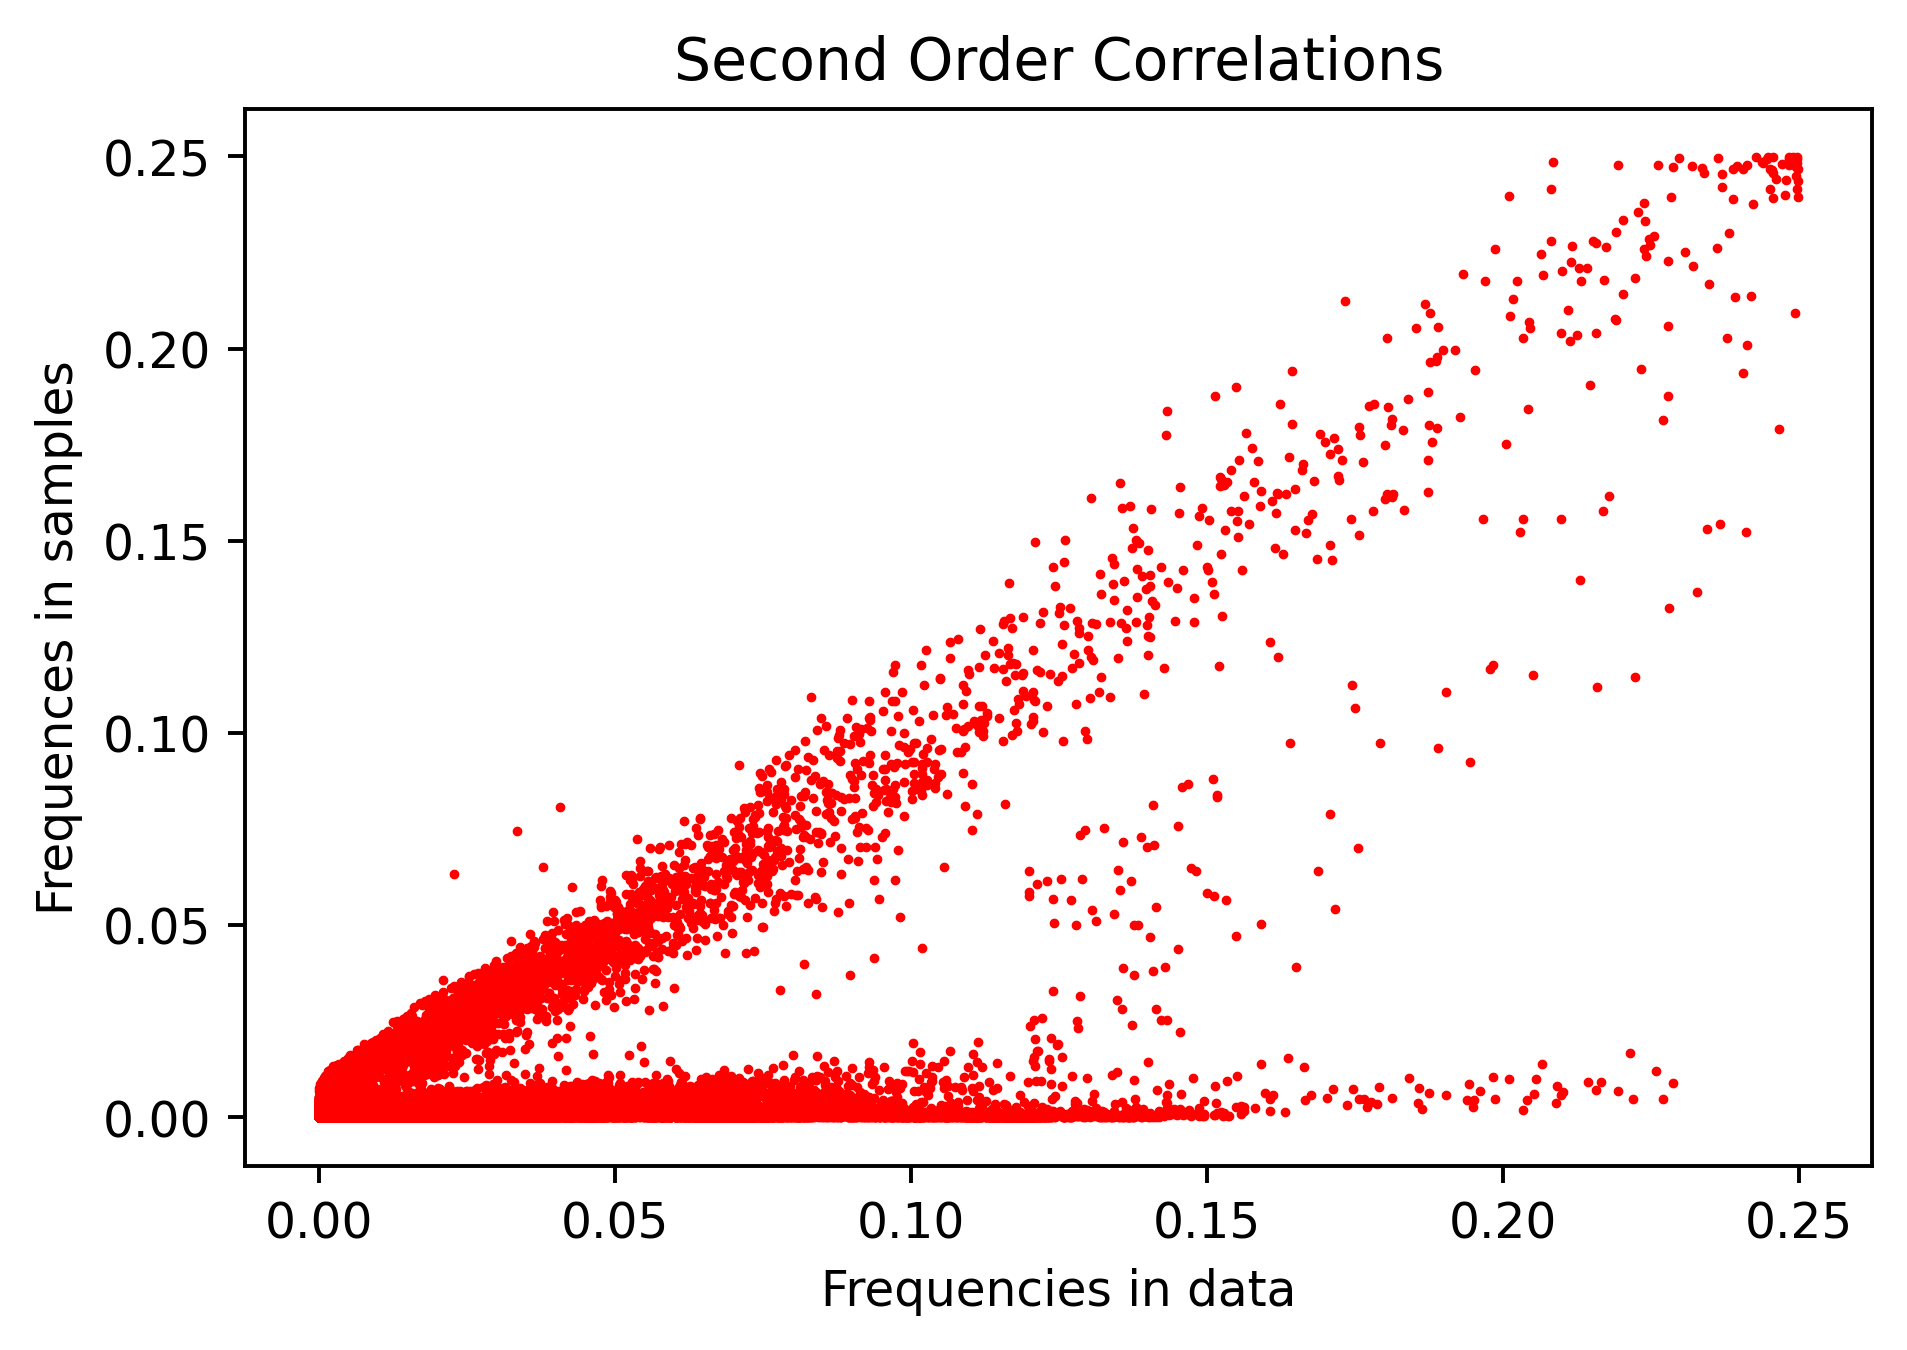

In [ ]:
print("Spearman: ", stats.pearsonr(freqs_data_flat, freqs_samp_flat)[0])
plt.scatter(freqs_data_flat, freqs_samp_flat, s=1, c='red')
plt.title("Second Order Correlations")
plt.xlabel("Frequencies in data")
plt.ylabel("Frequences in samples")
plt.show()

In [ ]:
X_data =  read_fasta("/content/lcc_short.fasta")

In [ ]:
X_sample =  read_fasta("/content/samples.txt")

Spearman:  0.9642222924882256


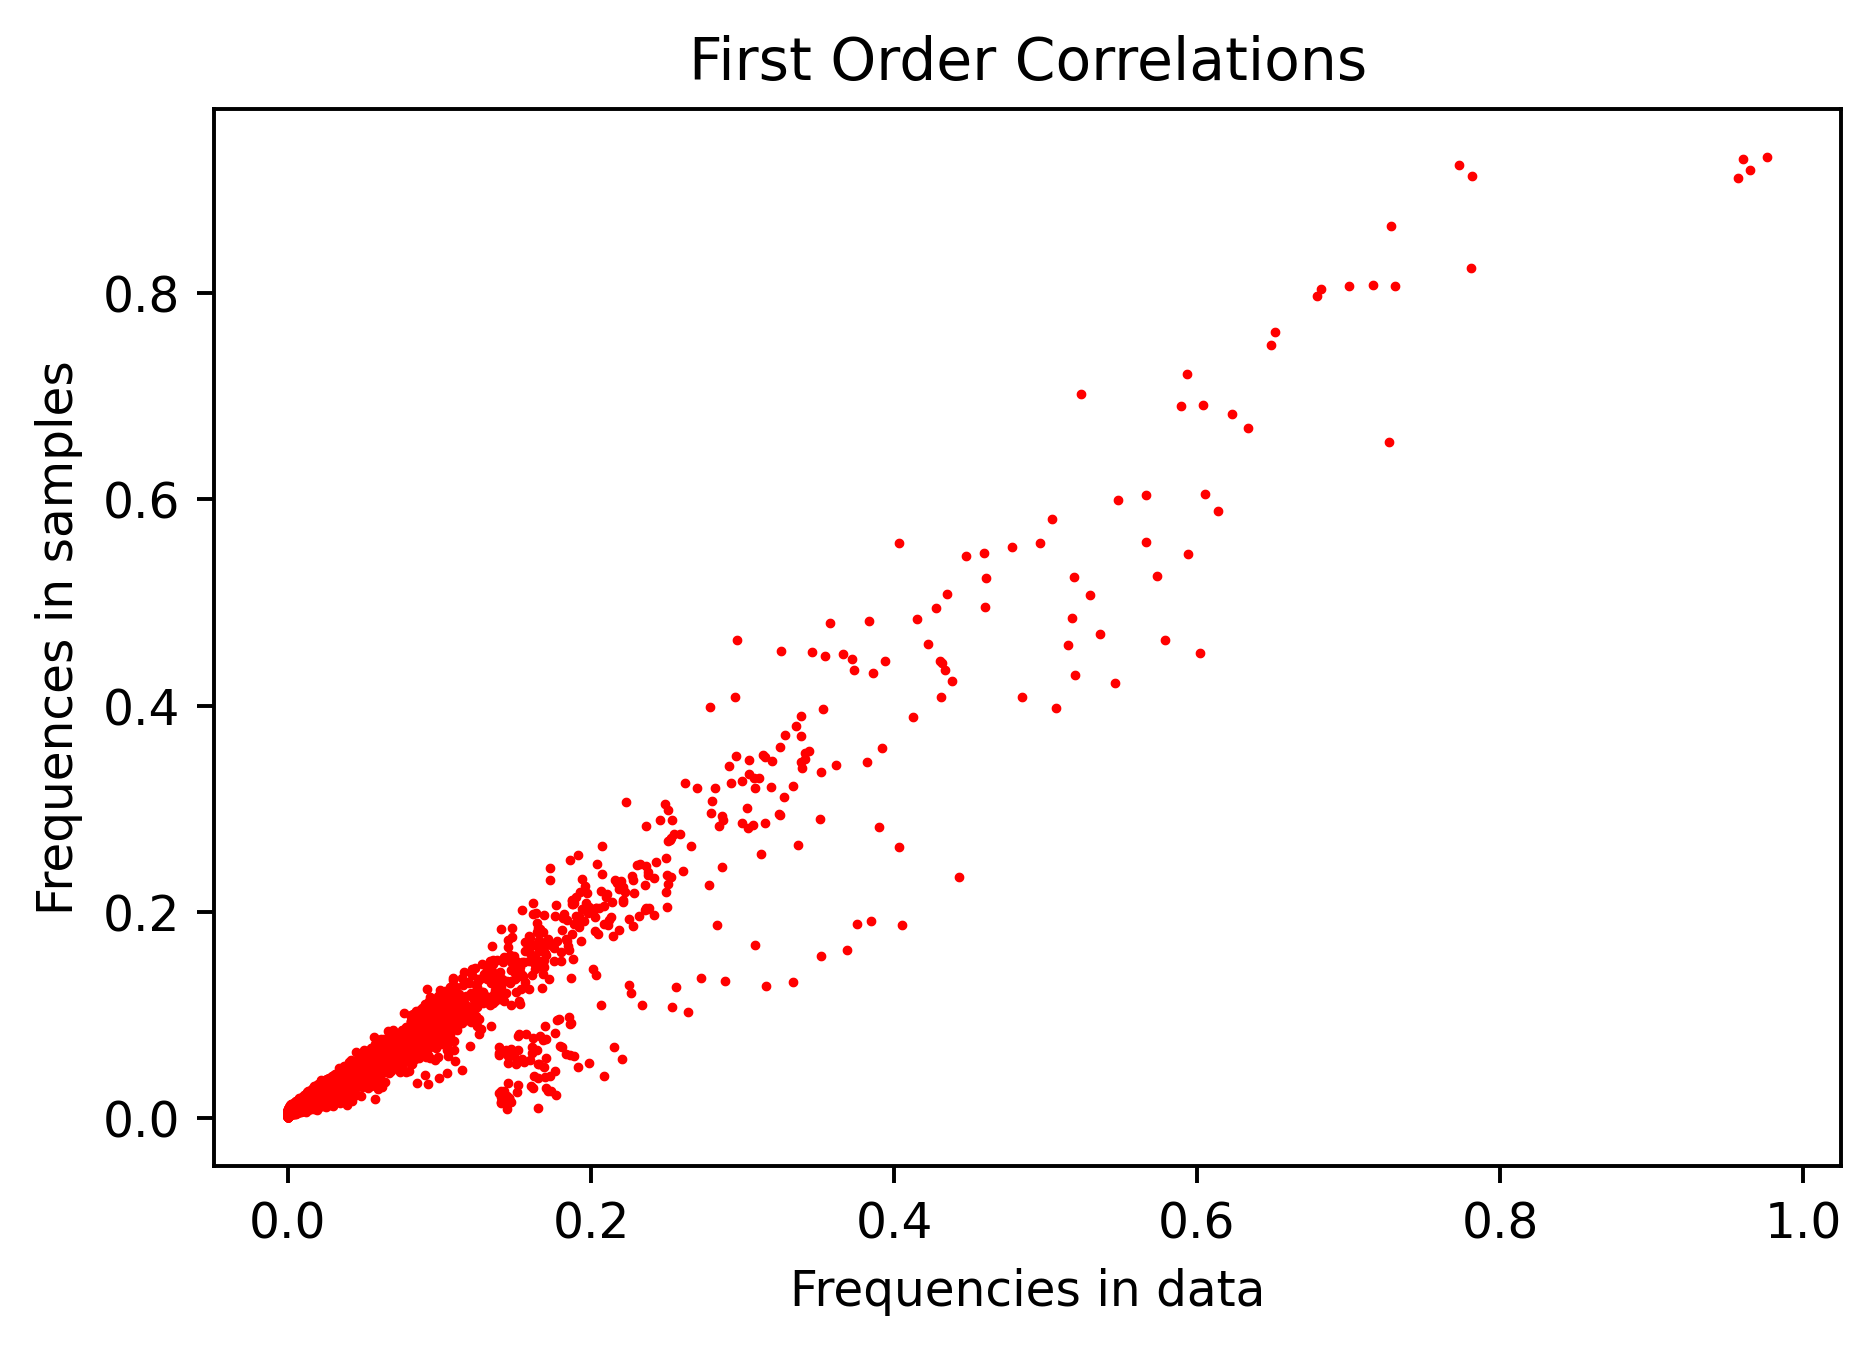

In [ ]:
first_order(X_data, X_sample)

#### Sequence Identity

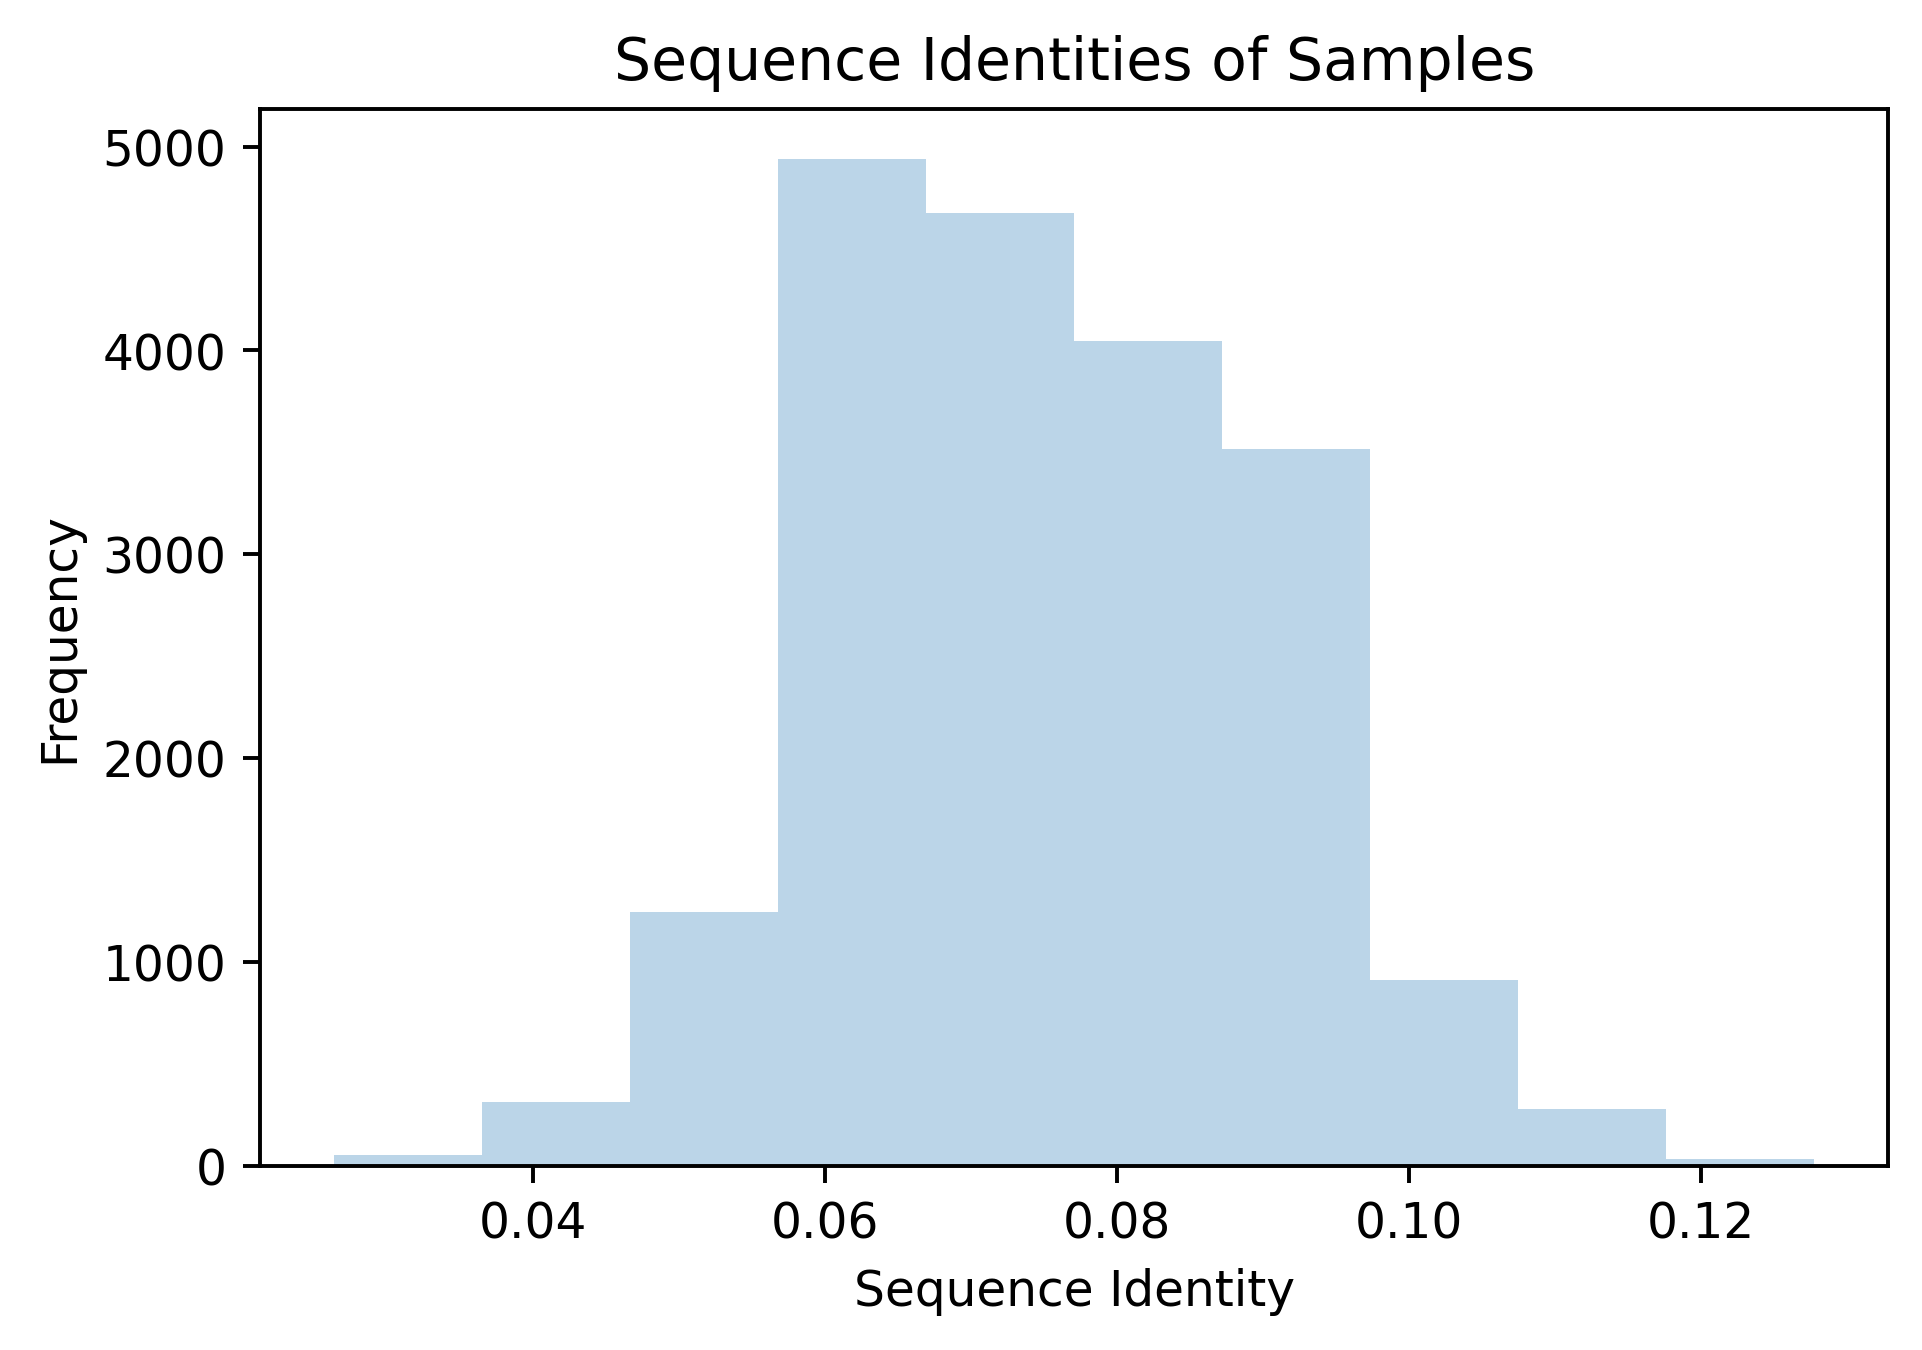

In [ ]:
def seq_identity(X_data, X_samp):
    """
    Plots a distribution of the percent sequence identity of each sampled
    sequence with closest sequence in the data
    """
    _, l, d = X_data.shape
    X_data = X_data.reshape(-1,l*d)
    X_samp = X_samp.reshape(-1,l*d)
    identities = []
    for s in tq.tqdm(X_samp):
        # this is valid because the sequences are aligned
        identity = np.min(l - np.sum(np.abs(X_data - s), axis=1)/2)/l
        identities.append(identity)

    return identities

# idents = seq_identity(X_data, X_sample)
# plt.hist(idents, alpha=0.3)
# plt.xlabel("Sequence Identity")
# plt.ylabel("Frequency")
# plt.title("Sequence Identities of Samples")
# plt.show()

### Contrastive Divergence

In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader, Dataset
import random

In [ ]:
L = 227
q = 21

class Potts(torch.nn.Module):
    def __init__(self):
        super(Potts, self).__init__()

        self.J = torch.nn.Parameter(torch.zeros(L*q, L*q), requires_grad=True) 
        self.h = torch.nn.Parameter(torch.zeros(L*q), requires_grad=True)

    def forward(self, X):
        # X = X.reshape(-1, L*A)
        J = ((self.J + self.J.T) / 2.0).to(device)   # make symmetric
        H = torch.tensor(0.0).to(device)
        for s in X:
            H += logE(s, self.h, J)
        return H

def loss_fn(model, Xin, Xout, L2=None):
    """
    Objective: negative (logp_in - logp_out)
    """
    ratio = model(Xin) - model(Xout)
    if L2 is not None:
        ratio += L2 * (torch.sum(model.J**2) + torch.sum(model.h**2))
    return ratio

def sample_from(model, num_samples=10, Tstart=2.0, Tend=1.0, Tsteps=10, seqlen=227, showProg=False):
    """
    sample from the potts model with MCMC with annealing
    """
    # maybe start from some seed sequence instead of random?
    X = torch.randint(21, (num_samples, seqlen)).to(device)

    temps = torch.flip(torch.linspace(Tstart, Tend, Tsteps), (0, ))
    with torch.no_grad():
        for t in temps:
            E = torch.zeros(num_samples)
            E_mut = torch.zeros(num_samples)
            if showProg:
                for i, s in tq.tqdm(enumerate(X)):
                    J = (model.J + model.J.T) / 2.0
                    E[i] = logE(s, model.h, J).item()
            else:
                for i, s in enumerate(X):
                    J = (model.J + model.J.T) / 2.0
                    E[i] = logE(s, model.h, J).item()
            X = X.view(num_samples*seqlen,)
            X_mut = torch.zeros_like(X)
            mut_pos = torch.from_numpy(np.random.choice(num_samples*seqlen, size=2*num_samples, replace=False))
            mut_res = torch.randint(1, 21, (len(mut_pos), )).to(device)
            X_mut[mut_pos] = (X[mut_pos] + mut_res) % 21
            X_mut = X_mut.view(num_samples, seqlen)
            X = X.view(num_samples, seqlen)
            if showProg:
                for i, s in tq.tqdm(enumerate(X)):
                    J = (model.J + model.J.T) / 2.0
                    E_mut[i] = logE(s, model.h, J).item()
            else:
                for i, s in enumerate(X):
                    J = (model.J + model.J.T) / 2.0
                    E_mut[i] = logE(s, model.h, J).item()

            deltaE = E_mut - E
            X_res = torch.zeros_like(X)
            accept = torch.logical_or(torch.rand(num_samples) > torch.exp(-deltaE/t), 
                                      deltaE < 0)
            reject = torch.logical_not(accept)
            X_res[accept] = X_mut[accept]
            X_res[reject] = X[reject]
    return X
            

For an unbiased comparison of contrastive divergence samples with bmDCA samples, try using bmDCA sampler with `potts_model.h` and `potts_model.J` as inputs to `bmdca_sample`

Also a speed boost: current `sample_from()` does 100seqs/min, but `bmdca_sample` is about 10x faster

In [ ]:
def save_params(h, J):
    """
    Saves model parameters h and J as ascii .txt files with the same format
    as bmDCA parameters.txt
    """
    

In [ ]:
def train_potts(X_data, batch_size=64, epochs=200, lr=1e-4, L2=0.1):
    """
    X_data: Dataset object wrapping a list of sequences encoded as integers
    """
    
    train, test = train_test_split(list(range(len(X_data))), test_size=.2)

    train_loader = DataLoader(X_data, batch_size=batch_size,
                          sampler=SubsetRandomSampler(train))
    test_loader = DataLoader(X_data, batch_size=batch_size,
                          sampler=SubsetRandomSampler(test))

    potts_model = Potts().to(device)

    optimizer = torch.optim.Adam(potts_model.parameters(), lr=lr)
    # scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, 1e-4, 1e-3, cycle_momentum=False)
    train_loss, test_loss = [], []

    for epoch in range(epochs):
        total_train_loss, total_test_loss = 0, 0        

        for Xin in tq.tqdm(train_loader):
            potts_model.train()
            optimizer.zero_grad()

            Xout = sample_from(potts_model, num_samples=batch_size)
            # print("computing loss")
            loss = loss_fn(potts_model, Xin, Xout, L2=L2)
            total_train_loss += loss.item()
            # print(loss.item())

            loss.backward()
            optimizer.step()

        train_loss.append(total_train_loss / len(train_loader))

        for Xin in test_loader:
            potts_model.eval()

            Xout = sample_from(potts_model, num_samples=batch_size)
            loss = loss_fn(potts_model, Xin, Xout, L2=L2)
            total_test_loss += loss.item()
            break
            
        test_loss.append(total_test_loss)
    torch.save(potts_model.state_dict(), "model.pt")
    plt.plot(train_loss)
    plt.plot(test_loss)
    plt.show()

    

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class SequenceData(Dataset):

    def __init__(self, X):
        if not torch.is_tensor(X):
            self.X = torch.from_numpy(X).to(device)
        else:
            self.X = X.to(device)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx]


In [ ]:
X_data = SequenceData(in_dist)

In [ ]:
train_potts(X_data, batch_size=64, epochs=10, lr=1e-4, L2=1.0)

KeyboardInterrupt: ignored

### Model evaluation

In [ ]:
potts_model = Potts()
potts_model.load_state_dict(torch.load("model.pt"))
potts_model.eval()

Potts()

Text(0, 0.5, 'Density')

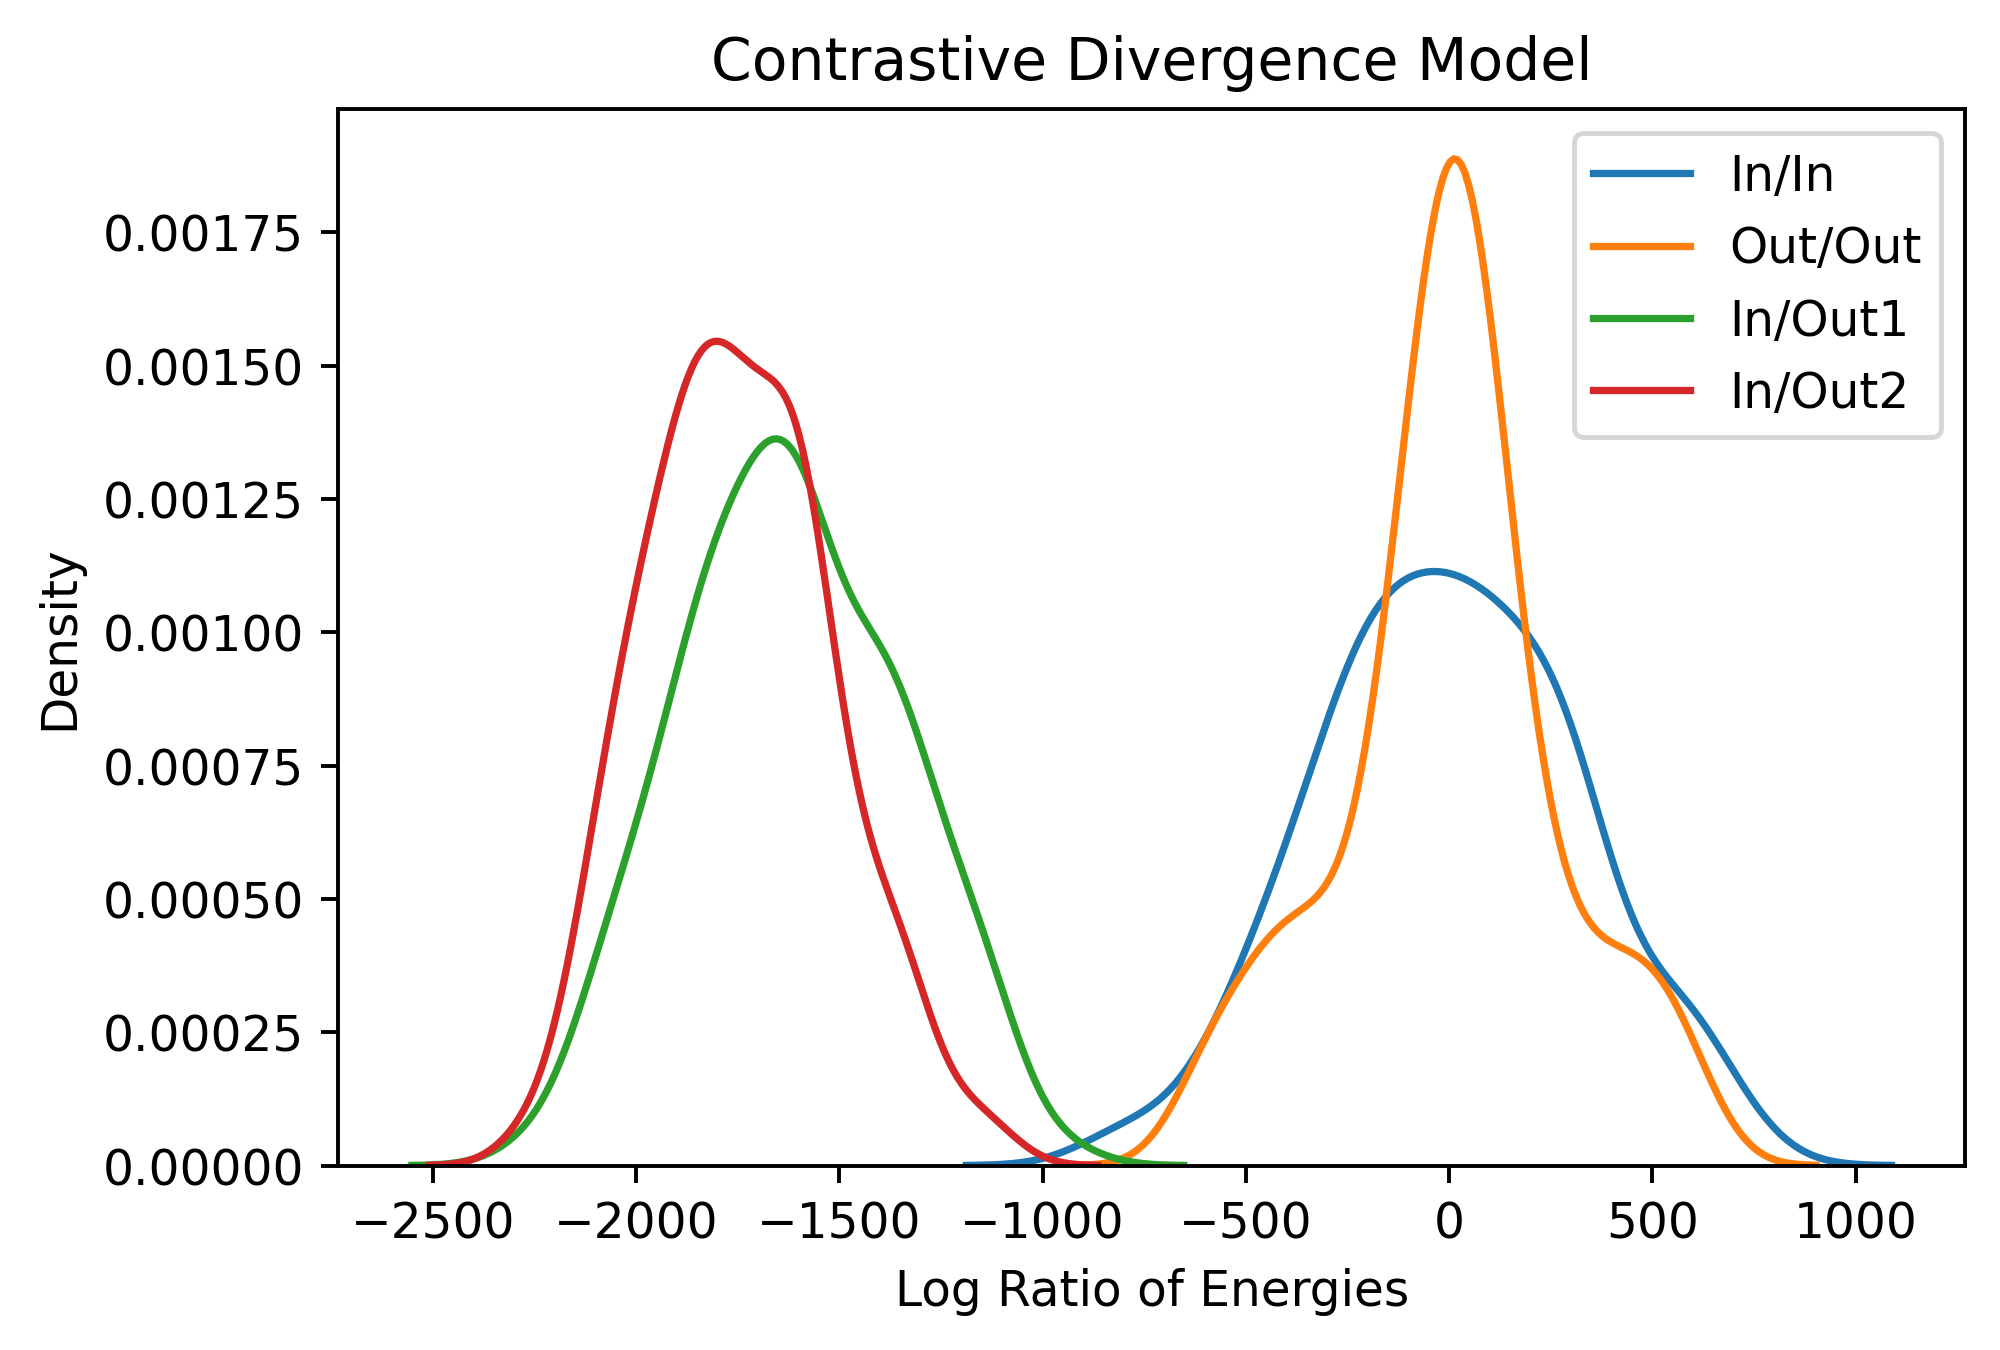

In [ ]:
import numpy as np

in_dist = get_numerical_aas("lcc_short.fasta")
out_dist1 = torch.from_numpy(np.array([np.random.permutation(s) for s in in_dist])).to(device)
out_dist2 = torch.from_numpy(np.array([np.concatenate((s[int(L/2):], s[:int(L/2)])) for s in in_dist])).to(device)
in_dist = torch.from_numpy(in_dist).to(device)

in_ratios = []
out_ratios = []
in_out1_ratios = []
in_out2_ratios = []
h = potts_model.h
J = (potts_model.J + potts_model.J.T) / 2.0
for i in tq.tqdm(range(200)):
    in_out1_ratios.append(logE(in_dist[i], h, J).item() - logE(out_dist1[i], h, J).item())
    in_out2_ratios.append(logE(in_dist[i], h, J).item() - logE(out_dist2[i], h, J).item())
    in_ratios.append(logE(in_dist[i], h, J).item() - logE(in_dist[i+1], h, J).item())
    out_ratios.append(logE(out_dist1[i], h, J).item() - logE(out_dist1[i+1], h, J).item())

import seaborn as sns

sns.kdeplot(in_ratios, label = "In/In")
sns.kdeplot(out_ratios, label = "Out/Out")
sns.kdeplot(in_out1_ratios, label = "In/Out1")
sns.kdeplot(in_out2_ratios, label = "In/Out2")

plt.legend()
plt.title('Contrastive Divergence Model')
plt.xlabel('Log Ratio of Energies')
plt.ylabel('Density')

Sample from model

In [ ]:
seqs = sample_from(potts_model, num_samples=200, Tstart=1.0, Tsteps=1, showProg=True)


In [ ]:
seqs_np = seqs.cpu().numpy().astype(np.int)
np.savetxt("potts_samples.txt", seqs_np, fmt="%d", delimiter=" ")

Look at frequencies

In [ ]:
int2fasta("potts_samples.txt", "potts.fasta")
samples = read_fasta("potts.fasta")
xin = read_fasta("lcc_short.fasta")

Spearman:  -0.009542844087746943


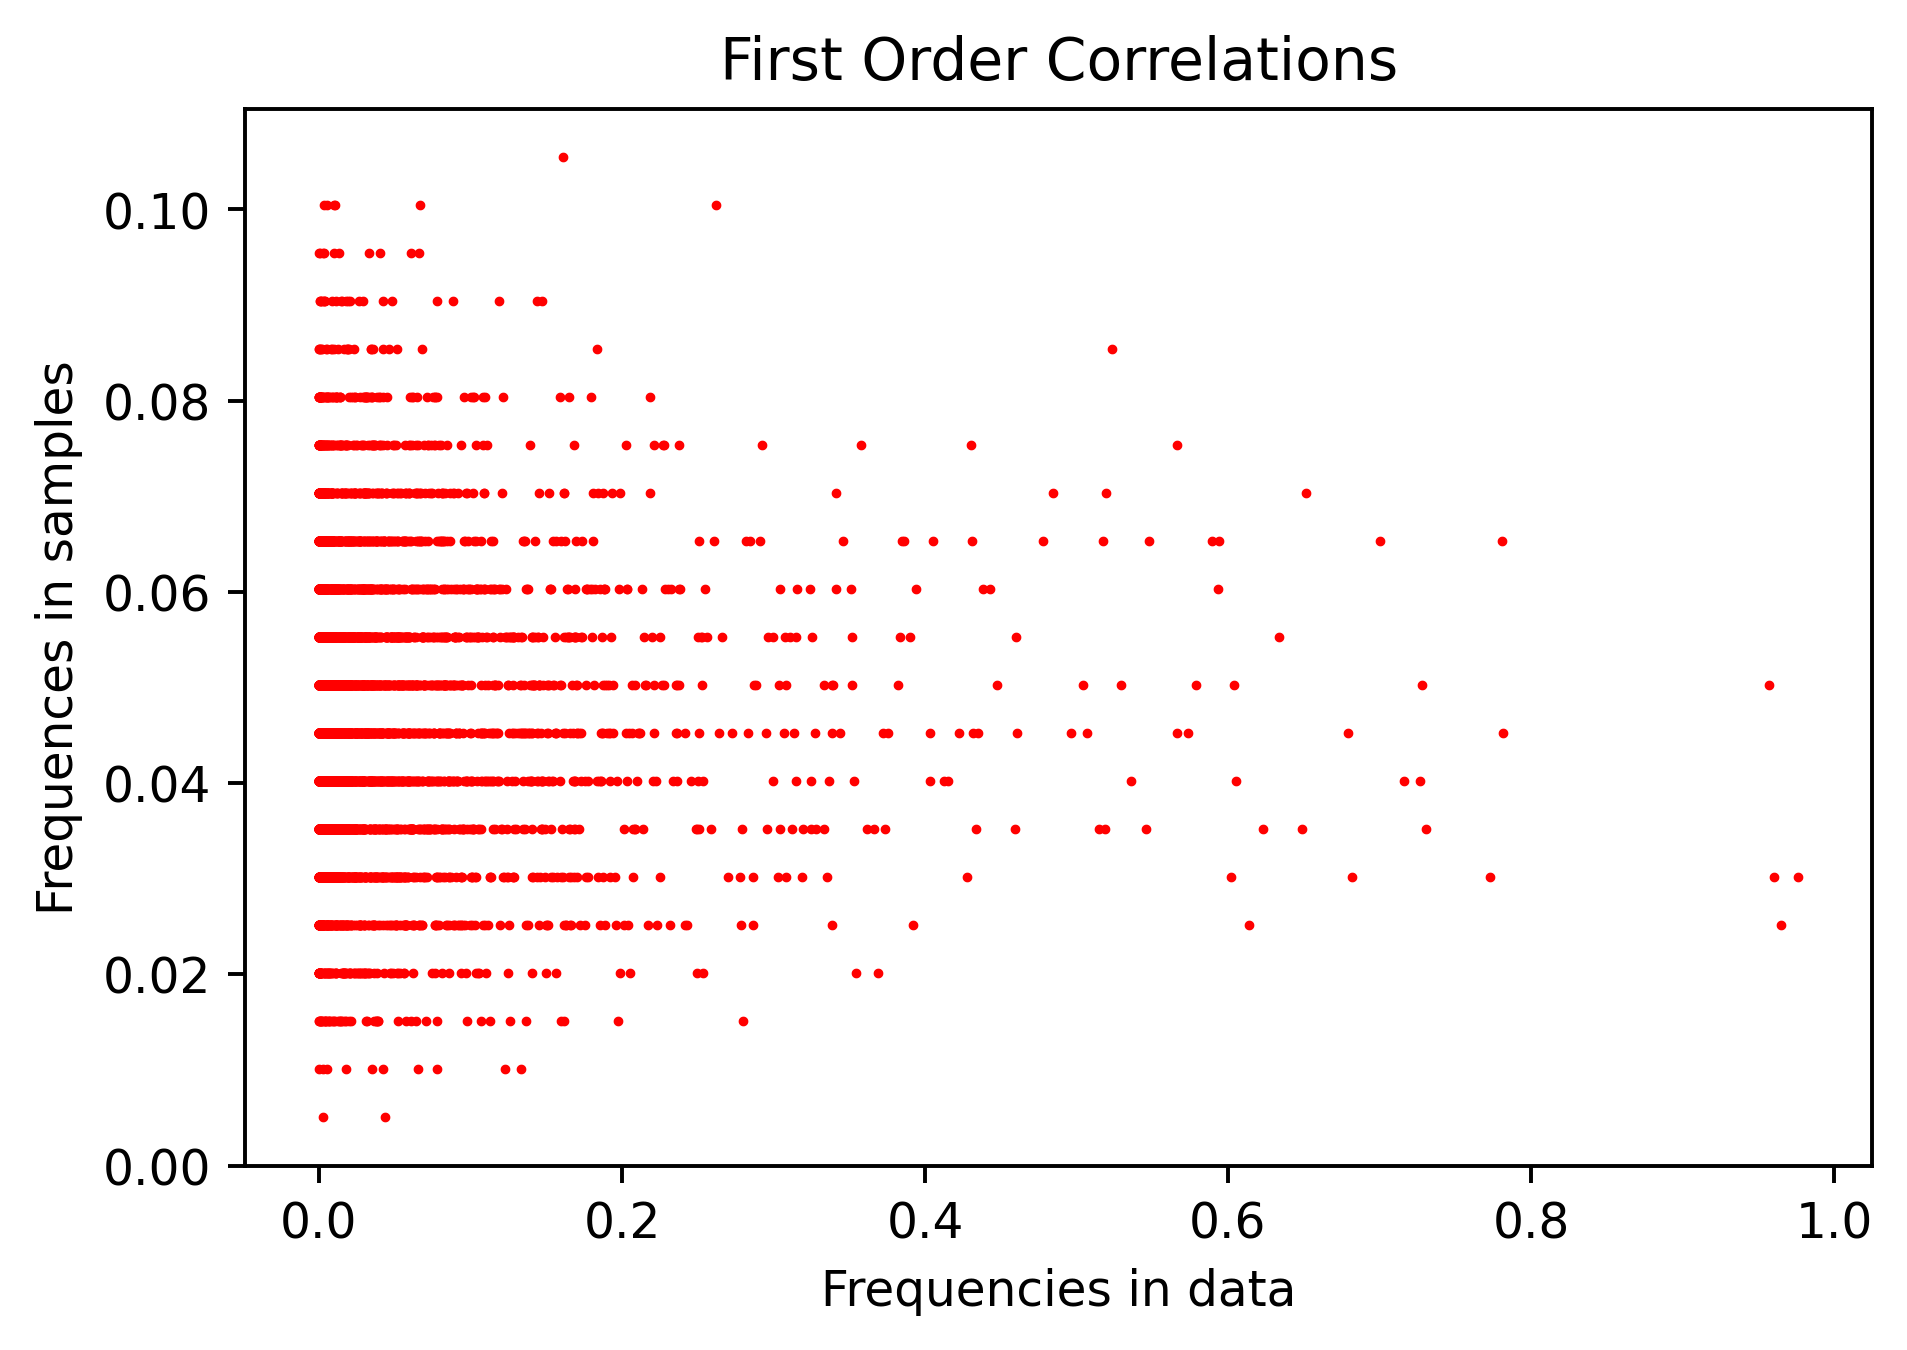

In [ ]:
first_order(xin, samples)

In [ ]:
freqs_data, freqs_samp = second_order(xin, samples)

KeyboardInterrupt: ignored

Sequence identity

In [ ]:
idents = seq_identity(X_data, seqs_np)
plt.hist(idents, alpha=0.3)
plt.xlabel("Sequence Identity")
plt.ylabel("Frequency")
plt.title("Sequence Identities of Samples")
plt.show()